# Install

Virual Enviroment
Create:
python3 -m venv national_football_env
virtualenv national_football_env

Activate:
source national_football_env/bin/activate

Deactivate:
deactivate

Delete:
rm -rf national_football_env

pip install -r requirements.txt

(pip install pandas
pip install numpy
pip install matplotlib
pip install seaborn
pip install scikit-learn
pip install streamlit)

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

# Import

In [2]:
df_results = pd.read_csv("data/results.csv", sep=",")
df_results["date"] = pd.to_datetime(df_results["date"])
df_results.tail()

date    home_team away_team  home_score  away_score    tournament  \
47394 2024-07-10  Netherlands   England           1           2     UEFA Euro   
47395 2024-07-10      Uruguay  Colombia           0           1  Copa América   
47396 2024-07-13       Canada   Uruguay           2           2  Copa América   
47397 2024-07-14        Spain   England           2           1     UEFA Euro   
47398 2024-07-14    Argentina  Colombia           1           0  Copa América   

                city        country  neutral  
47394       Dortmund        Germany     True  
47395      Charlotte  United States     True  
47396      Charlotte  United States     True  
47397         Berlin        Germany     True  
47398  Miami Gardens  United States     True

In [3]:
# Function to calculate points based on scores, modified to return two rows per match
def calculate_scores(row):
    home_net_goals = row['home_score'] - row['away_score']  # Goals scored minus goals conceded for the home team
    away_net_goals = row['away_score'] - row['home_score']  # Goals scored minus goals conceded for the away team

    if row['home_score'] > row['away_score']:
        return [
            (row['date'], row['home_team'], 3, row['home_score'],  home_net_goals, row['away_team'],0,row['away_score'], away_net_goals),
            (row['date'], row['away_team'], 0, row['away_score'], away_net_goals, row['home_team'], 3, row['home_score'], home_net_goals)
        ]
    elif row['home_score'] < row['away_score']:
        return [
            (row['date'], row['home_team'], 0, row['home_score'], home_net_goals, row['away_team'],3, row['away_score'], away_net_goals),
            (row['date'], row['away_team'], 3, row['away_score'],  away_net_goals, row['home_team'],0, row['home_score'], home_net_goals)
        ]
    else:
        return [
            (row['date'], row['home_team'], 1, row['home_score'],  home_net_goals, row['away_team'],1, row['away_score'], away_net_goals),
            (row['date'], row['away_team'], 1, row['away_score'], away_net_goals, row['home_team'],1, row['home_score'], home_net_goals)
        ]

In [4]:
# Apply the point calculating function and create a DataFrame for points and goals for each team
df_all_results_list = df_results.apply(lambda row: calculate_scores(row), axis=1)
df_all_results = pd.DataFrame([item for sublist in df_all_results_list for item in sublist], columns=['date', 'team', 'points', 'team_goals',"net_score", 'opponent','opponent_points','opponent_goals','opponent_net_score'])

df_all_results

date       team  points  team_goals  net_score   opponent  \
0     1872-11-30   Scotland       1           0          0    England   
1     1872-11-30    England       1           0          0   Scotland   
2     1873-03-08    England       3           4          2   Scotland   
3     1873-03-08   Scotland       0           2         -2    England   
4     1874-03-07   Scotland       3           2          1    England   
...          ...        ...     ...         ...        ...        ...   
94793 2024-07-13    Uruguay       1           2          0     Canada   
94794 2024-07-14      Spain       3           2          1    England   
94795 2024-07-14    England       0           1         -1      Spain   
94796 2024-07-14  Argentina       3           1          1   Colombia   
94797 2024-07-14   Colombia       0           0         -1  Argentina   

       opponent_points  opponent_goals  opponent_net_score  
0                    1               0                   0  
1                    1               0                   0  
2                    0               2                  -2  
3                    3               4                   2  
4                    0               1                  -1  
...                ...             ...                 ...  
94793                1               2                   0  
94794                0               1                  -1  
94795                3               2                   1  
94796                0               0                  -1  
94797                3               1                   1  

[94798 rows x 9 columns]

In [5]:
# Sort data by date to correctly compute rolling sums
df_all_results = df_all_results.sort_values('date')

# Calculate rolling sum of goals and points for the last 10 games for each team
df_all_results['rolling_net_score'] = df_all_results.groupby('team')['net_score'].transform(lambda x: x.rolling(window=10, min_periods=1).sum())
df_all_results['rolling_points'] = df_all_results.groupby('team')['points'].transform(lambda x: x.rolling(window=10, min_periods=1).sum())
df_all_results['opponent_rolling_net_score'] = df_all_results.groupby('opponent')['opponent_net_score'].transform(lambda x: x.rolling(window=10, min_periods=1).sum())
df_all_results['opponent_rolling_points'] = df_all_results.groupby('opponent')['opponent_points'].transform(lambda x: x.rolling(window=10, min_periods=1).sum())


# Display the updated DataFrame
df_all_results

date       team  points  team_goals  net_score   opponent  \
0     1872-11-30   Scotland       1           0          0    England   
1     1872-11-30    England       1           0          0   Scotland   
2     1873-03-08    England       3           4          2   Scotland   
3     1873-03-08   Scotland       0           2         -2    England   
4     1874-03-07   Scotland       3           2          1    England   
...          ...        ...     ...         ...        ...        ...   
94792 2024-07-13     Canada       1           2          0    Uruguay   
94795 2024-07-14    England       0           1         -1      Spain   
94796 2024-07-14  Argentina       3           1          1   Colombia   
94794 2024-07-14      Spain       3           2          1    England   
94797 2024-07-14   Colombia       0           0         -1  Argentina   

       opponent_points  opponent_goals  opponent_net_score  rolling_net_score  \
0                    1               0                   0                0.0   
1                    1               0                   0                0.0   
2                    0               2                  -2                2.0   
3                    3               4                   2               -2.0   
4                    0               1                  -1               -1.0   
...                ...             ...                 ...                ...   
94792                1               2                   0               -6.0   
94795                3               2                   1                4.0   
94796                0               0                  -1               17.0   
94794                0               1                  -1               20.0   
94797                3               1                   1               18.0   

       rolling_points  opponent_rolling_net_score  opponent_rolling_points  
0                 1.0                         0.0                      1.0  
1                 1.0                         0.0                      1.0  
2                 4.0                        -2.0                      1.0  
3                 1.0                         2.0                      4.0  
4                 4.0                         1.0                      4.0  
...               ...                         ...                      ...  
94792            10.0                        12.0                     18.0  
94795            16.0                        20.0                     28.0  
94796            28.0                        18.0                     25.0  
94794            28.0                         4.0                     16.0  
94797            25.0                        17.0                     28.0  

[94798 rows x 13 columns]

In [18]:
def calculate_elo(row, last_elo_ratings={}):
    team1 = row['team']
    team2 = row['opponent']
    current_date = row['date']

    # Initialize Elo ratings if not already set
    elo_team1 = last_elo_ratings.get(team1, 1500)
    elo_team2 = last_elo_ratings.get(team2, 1500)

    # Set initial Elo ratings if it is the first time encountering the team/opponent
    last_elo_ratings.setdefault(team1, elo_team1)
    last_elo_ratings.setdefault(team2, elo_team2)

    k = 10

    # Determine match result
    if row['points'] == 3:
        team1_result = 1
        team2_result = 0
    elif row['points'] == 0:
        team1_result = 0
        team2_result = 1
    else:
        team1_result = 0.5
        team2_result = 0.5

    # Calculate expected scores
    expected_team1 = 1 / (1 + 10 ** ((elo_team2 - elo_team1) / 600))
    expected_team2 = 1 / (1 + 10 ** ((elo_team1 - elo_team2) / 600))

    # Update Elo ratings
    new_elo_team1 = elo_team1 + k * (team1_result - expected_team1)
    new_elo_team2 = elo_team2 + k * (team2_result - expected_team2)

    print(f"{current_date} - {team1}({int(new_elo_team1)}) : {team2}({int(new_elo_team2)})")

    # Store updated Elo ratings
    last_elo_ratings[team1] = new_elo_team1
    last_elo_ratings[team2] = new_elo_team2

    # Return updated Elo ratings for both team and opponent
    return pd.Series({'elo_rating': new_elo_team1, 'opponent_elo_rating': new_elo_team2})

In [22]:
# Apply the function to the DataFrame
elo_ratings = df_all_results.apply(lambda row: calculate_elo(row), axis=1)
df_all_results["team_elo_rating"] = elo_ratings["elo_rating"]
df_all_results["opponent_elo_rating"] = elo_ratings["opponent_elo_rating"]
del elo_ratings
df_all_results

1872-11-30 00:00:00 - Scotland(1805) : England(2114)
1872-11-30 00:00:00 - England(2112) : Scotland(1807)
1873-03-08 00:00:00 - England(2114) : Scotland(1805)
1873-03-08 00:00:00 - Scotland(1803) : England(2116)
1874-03-07 00:00:00 - Scotland(1810) : England(2109)
1874-03-07 00:00:00 - England(2101) : Scotland(1818)
1875-03-06 00:00:00 - England(2098) : Scotland(1820)
1875-03-06 00:00:00 - Scotland(1823) : England(2096)
1876-03-04 00:00:00 - England(2089) : Scotland(1830)
1876-03-04 00:00:00 - Scotland(1838) : England(2081)
1876-03-25 00:00:00 - Scotland(1842) : Wales(1806)
1876-03-25 00:00:00 - Wales(1802) : Scotland(1847)
1877-03-03 00:00:00 - England(2074) : Scotland(1854)
1877-03-03 00:00:00 - Scotland(1861) : England(2067)
1877-03-05 00:00:00 - Wales(1797) : Scotland(1866)
1877-03-05 00:00:00 - Scotland(1870) : Wales(1793)
1878-03-02 00:00:00 - Scotland(1877) : England(2060)
1878-03-02 00:00:00 - England(2054) : Scotland(1883)
1878-03-23 00:00:00 - Scotland(1888) : Wales(1789)
187

date       team  points  team_goals  net_score  rolling_points  \
94705 2024-06-25     Canada       3           1          1            14.0   
94704 2024-06-25       Peru       0           0         -1            12.0   
94703 2024-06-25     Poland       1           1          0            16.0   
94707 2024-06-25  Argentina       3           1          1            27.0   
94701 2024-06-25    Austria       3           3          1            25.0   
...          ...        ...     ...         ...        ...             ...   
94792 2024-07-13     Canada       1           2          0            10.0   
94795 2024-07-14    England       0           1         -1            16.0   
94796 2024-07-14  Argentina       3           1          1            28.0   
94794 2024-07-14      Spain       3           2          1            28.0   
94797 2024-07-14   Colombia       0           0         -1            25.0   

       rolling_net_score  team_elo_rating     opponent  opponent_points  \
94705               -4.0      1791.857126         Peru                0   
94704               -1.0      1897.495882       Canada                3   
94703                6.0      1943.597853       France                1   
94707               14.0      2272.634702        Chile                0   
94701               15.0      1962.505096  Netherlands                0   
...                  ...              ...          ...              ...   
94792               -6.0      1803.101184      Uruguay                1   
94795                4.0      2174.447759        Spain                3   
94796               17.0      2277.714978     Colombia                0   
94794               20.0      2261.484417      England                0   
94797               18.0      2154.908071    Argentina                3   

       opponent_goals  opponent_net_score  opponent_rolling_points  \
94705               0                  -1                     12.0   
94704               1                   1                     14.0   
94703               1                   0                     19.0   
94707               0                  -1                     12.0   
94701               2                  -1                     22.0   
...               ...                 ...                      ...   
94792               2                   0                     18.0   
94795               2                   1                     28.0   
94796               0                  -1                     25.0   
94794               1                  -1                     16.0   
94797               1                   1                     28.0   

       opponent_rolling_net_score  opponent_elo_rating  
94705                        -1.0          1903.551377  
94704                        -4.0          1797.912620  
94703                        20.0          2220.886306  
94707                         2.0          1896.004384  
94701                        19.0          2153.896401  
...                           ...                  ...  
94792                        12.0          2074.209492  
94795                        20.0          2257.272422  
94796                        18.0          2158.786461  
94794                         4.0          2170.235764  
94797                        17.0          2281.593368  

[100 rows x 15 columns]

In [50]:
df_all_results["rolling_points_diff"] = df_all_results["rolling_points"] - df_all_results["opponent_rolling_points"]
df_all_results["rolling_score_diff"] = df_all_results["rolling_net_score"] - df_all_results["opponent_rolling_net_score"]
df_all_results["elo_diff"] = df_all_results["team_elo_rating"] - df_all_results["opponent_elo_rating"]
df_all_results

date       team  points  team_goals  net_score  rolling_points  \
0     1872-11-30   Scotland       1           0          0             1.0   
1     1872-11-30    England       1           0          0             1.0   
2     1873-03-08    England       3           4          2             4.0   
3     1873-03-08   Scotland       0           2         -2             1.0   
4     1874-03-07   Scotland       3           2          1             4.0   
...          ...        ...     ...         ...        ...             ...   
94792 2024-07-13     Canada       1           2          0            10.0   
94795 2024-07-14    England       0           1         -1            16.0   
94796 2024-07-14  Argentina       3           1          1            28.0   
94794 2024-07-14      Spain       3           2          1            28.0   
94797 2024-07-14   Colombia       0           0         -1            25.0   

       rolling_net_score  team_elo_rating   opponent  opponent_points  \
0                    0.0      1805.268048    England                1   
1                    0.0      2112.009907   Scotland                1   
2                    2.0      2114.383980   Scotland                0   
3                   -2.0      1803.215461    England                3   
4                   -1.0      1810.906287    England                0   
...                  ...              ...        ...              ...   
94792               -6.0      1803.101184    Uruguay                1   
94795                4.0      2174.447759      Spain                3   
94796               17.0      2277.714978   Colombia                0   
94794               20.0      2261.484417    England                0   
94797               18.0      2154.908071  Argentina                3   

       opponent_goals  opponent_net_score  opponent_rolling_points  \
0                   0                   0                      1.0   
1                   0                   0                      1.0   
2                   2                  -2                      1.0   
3                   4                   2                      4.0   
4                   1                  -1                      4.0   
...               ...                 ...                      ...   
94792               2                   0                     18.0   
94795               2                   1                     28.0   
94796               0                  -1                     25.0   
94794               1                  -1                     16.0   
94797               1                   1                     28.0   

       opponent_rolling_net_score  opponent_elo_rating  rolling_points_diff  \
0                             0.0          2114.672636                  0.0   
1                             0.0          1807.930776                  0.0   
2                            -2.0          1805.556703                  3.0   
3                             2.0          2116.725222                 -3.0   
4                             1.0          2109.034396                  0.0   
...                           ...                  ...                  ...   
94792                        12.0          2074.209492                 -8.0   
94795                        20.0          2257.272422                -12.0   
94796                        18.0          2158.786461                  3.0   
94794                         4.0          2170.235764                 12.0   
94797                        17.0          2281.593368                 -3.0   

       rolling_score_diff    elo_diff  
0                     0.0 -309.404588  
1                     0.0  304.079131  
2                     4.0  308.827277  
3                    -4.0 -313.509760  
4                    -2.0 -298.128109  
...                   ...         ...  
94792               -18.0 -271.108308  
94795               -16.0  -82.824663  
94796                -1.0  118.928517  
94794   

In [51]:
#Reorder columns
df_all_results = df_all_results[['date', 'team', 'points', 'team_goals',"net_score", "rolling_points", "rolling_net_score", "team_elo_rating", 'opponent','opponent_points','opponent_goals','opponent_net_score',"opponent_rolling_points", "opponent_rolling_net_score","opponent_elo_rating","rolling_points_diff","rolling_score_diff","elo_diff"]]
df_all_results

date       team  points  team_goals  net_score  rolling_points  \
0     1872-11-30   Scotland       1           0          0             1.0   
1     1872-11-30    England       1           0          0             1.0   
2     1873-03-08    England       3           4          2             4.0   
3     1873-03-08   Scotland       0           2         -2             1.0   
4     1874-03-07   Scotland       3           2          1             4.0   
...          ...        ...     ...         ...        ...             ...   
94792 2024-07-13     Canada       1           2          0            10.0   
94795 2024-07-14    England       0           1         -1            16.0   
94796 2024-07-14  Argentina       3           1          1            28.0   
94794 2024-07-14      Spain       3           2          1            28.0   
94797 2024-07-14   Colombia       0           0         -1            25.0   

       rolling_net_score  team_elo_rating   opponent  opponent_points  \
0                    0.0      1805.268048    England                1   
1                    0.0      2112.009907   Scotland                1   
2                    2.0      2114.383980   Scotland                0   
3                   -2.0      1803.215461    England                3   
4                   -1.0      1810.906287    England                0   
...                  ...              ...        ...              ...   
94792               -6.0      1803.101184    Uruguay                1   
94795                4.0      2174.447759      Spain                3   
94796               17.0      2277.714978   Colombia                0   
94794               20.0      2261.484417    England                0   
94797               18.0      2154.908071  Argentina                3   

       opponent_goals  opponent_net_score  opponent_rolling_points  \
0                   0                   0                      1.0   
1                   0                   0                      1.0   
2                   2                  -2                      1.0   
3                   4                   2                      4.0   
4                   1                  -1                      4.0   
...               ...                 ...                      ...   
94792               2                   0                     18.0   
94795               2                   1                     28.0   
94796               0                  -1                     25.0   
94794               1                  -1                     16.0   
94797               1                   1                     28.0   

       opponent_rolling_net_score  opponent_elo_rating  rolling_points_diff  \
0                             0.0          2114.672636                  0.0   
1                             0.0          1807.930776                  0.0   
2                            -2.0          1805.556703                  3.0   
3                             2.0          2116.725222                 -3.0   
4                             1.0          2109.034396                  0.0   
...                           ...                  ...                  ...   
94792                        12.0          2074.209492                 -8.0   
94795                        20.0          2257.272422                -12.0   
94796                        18.0          2158.786461                  3.0   
94794                         4.0          2170.235764                 12.0   
94797                        17.0          2281.593368                 -3.0   

       rolling_score_diff    elo_diff  
0                     0.0 -309.404588  
1                     0.0  304.079131  
2                     4.0  308.827277  
3                    -4.0 -313.509760  
4                    -2.0 -298.128109  
...                   ...         ...  
94792               -18.0 -271.108308  
94795               -16.0  -82.824663  
94796                -1.0  118.928517  
94794   

In [52]:
df_results = df_all_results[::2]
df_results = df_results.reset_index(drop=True)
df_results

date         team  points  team_goals  net_score  rolling_points  \
0     1872-11-30     Scotland       1           0          0             1.0   
1     1873-03-08      England       3           4          2             4.0   
2     1874-03-07     Scotland       3           2          1             4.0   
3     1875-03-06      England       1           2          0             5.0   
4     1876-03-04      England       0           0         -3             5.0   
...          ...          ...     ...         ...        ...             ...   
47394 2024-07-10  Netherlands       0           1         -1            19.0   
47395 2024-07-10      Uruguay       0           0         -1            20.0   
47396 2024-07-13      Uruguay       1           2          0            18.0   
47397 2024-07-14      England       0           1         -1            16.0   
47398 2024-07-14        Spain       3           2          1            28.0   

       rolling_net_score  team_elo_rating  opponent  opponent_points  \
0                    0.0      1805.268048   England                1   
1                    2.0      2114.383980  Scotland                0   
2                   -1.0      1810.906287   England                0   
3                    1.0      2098.973981  Scotland                1   
4                   -2.0      2089.129704  Scotland                3   
...                  ...              ...       ...              ...   
47394               14.0      2152.709569   England                3   
47395               14.0      2083.380232  Colombia                3   
47396               12.0      2076.634543    Canada                1   
47397                4.0      2174.447759     Spain                3   
47398               20.0      2261.484417   England                0   

       opponent_goals  opponent_net_score  opponent_rolling_points  \
0                   0                   0                      1.0   
1                   2                  -2                      1.0   
2                   1                  -1                      4.0   
3                   2                   0                      5.0   
4                   3                   3                      8.0   
...               ...                 ...                      ...   
47394               2                   1                     16.0   
47395               1                   1                     28.0   
47396               2                   0                     10.0   
47397               2                   1                     28.0   
47398               1                  -1                     16.0   

       opponent_rolling_net_score  opponent_elo_rating  rolling_points_diff  \
0                             0.0          2114.672636                  0.0   
1                            -2.0          1805.556703                  3.0   
2                             1.0          2109.034396                  0.0   
3                            -1.0          1820.966703                  0.0   
4                             2.0          1830.810980                 -3.0   
...                           ...                  ...                  ...   
47394                         4.0          2173.943887                  3.0   
47395                        20.0          2158.452391                 -8.0   
47396                        -6.0          1800.676134                  8.0   
47397                        20.0          2257.272422                -12.0   
47398                         4.0          2170.235764                 12.0   

       rolling_score_diff    elo_diff  
0                     0.0 -309.404588  
1                     4.0  308.827277  
2                    -2.0 -298.128109  
3                     2.0  278.007278  
4                    -4.0  258.318724  
...                   ...         ...  
47394                10.0  -21.234318  
47395                -6.0  -75.072159  
47396                18.0  275.95840

In [152]:
unique_team_list = df_results["team"].unique()

# STATISTICS

## ROLLING POINTS DIFFERENCE

In [41]:
# First, perform the aggregation to sum wins and count games:
stats_point_diff = df_results.groupby('rolling_points_diff').agg(
    total_wins=('points', lambda x: (x == 3).sum()),  # Summing the boolean 'win' column to count True values.
    total_ties=('points', lambda x: (x == 1).sum()),
    total_losses=('points', lambda x: (x == 0).sum()),
    total_games=('points', 'count')  # Counting all rows to get the number of games.
)

# Now, calculate the probability of wins:
stats_point_diff['win_probability'] = stats_point_diff['total_wins'] / stats_point_diff['total_games']
stats_point_diff['tie_probability'] = stats_point_diff['total_ties'] / stats_point_diff['total_games']
stats_point_diff['loss_probability'] = stats_point_diff['total_losses'] / stats_point_diff['total_games']

stats_point_diff

total_wins  total_ties  total_losses  total_games  \
rolling_points_diff                                                      
-30.0                         0           0             4            4   
-29.0                         0           0             1            1   
-28.0                         0           0             1            1   
-27.0                         0           0            12           12   
-26.0                         0           0            10           10   
...                         ...         ...           ...          ...   
 26.0                        11           0             0           11   
 27.0                        15           0             0           15   
 28.0                         1           0             0            1   
 29.0                         1           0             0            1   
 30.0                         3           0             0            3   

                     win_probability  tie_probability  loss_probability  
rolling_points_diff                                                      
-30.0                            0.0              0.0               1.0  
-29.0                            0.0              0.0               1.0  
-28.0                            0.0              0.0               1.0  
-27.0                            0.0              0.0               1.0  
-26.0                            0.0              0.0               1.0  
...                              ...              ...               ...  
 26.0                            1.0              0.0               0.0  
 27.0                            1.0              0.0               0.0  
 28.0                            1.0              0.0               0.0  
 29.0                            1.0              0.0               0.0  
 30.0                            1.0              0.0               0.0  

[61 rows x 7 columns]

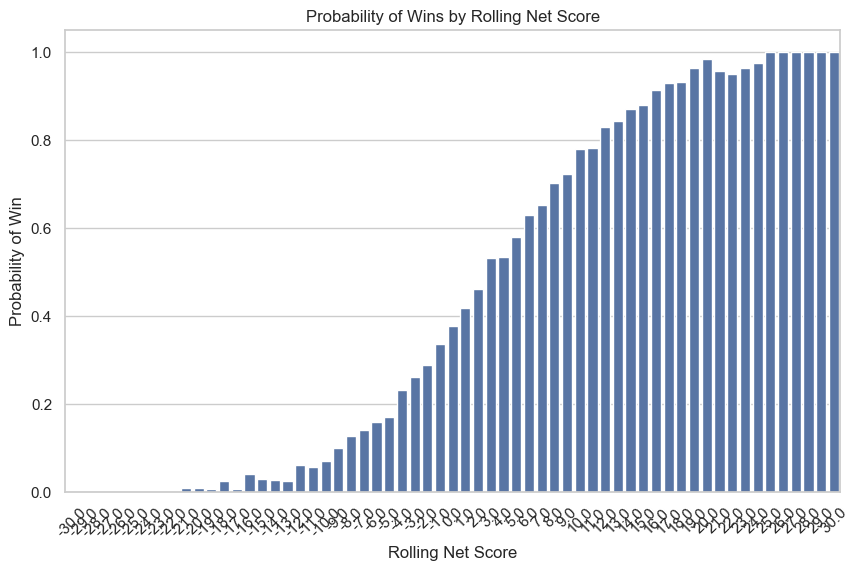

In [39]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar plot to show the probability for each 'rolling_net_score'
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.barplot(x=stats_point_diff.index, y="win_probability", data=stats_point_diff)
plt.title('Probability of Wins by Rolling Net Score')  # Title of the plot
plt.xlabel('Rolling Net Score')  # X-axis label
plt.ylabel('Probability of Win')  # Y-axis label
plt.xticks(rotation=45)  # Rotate the x labels for better readability if necessary
plt.show()

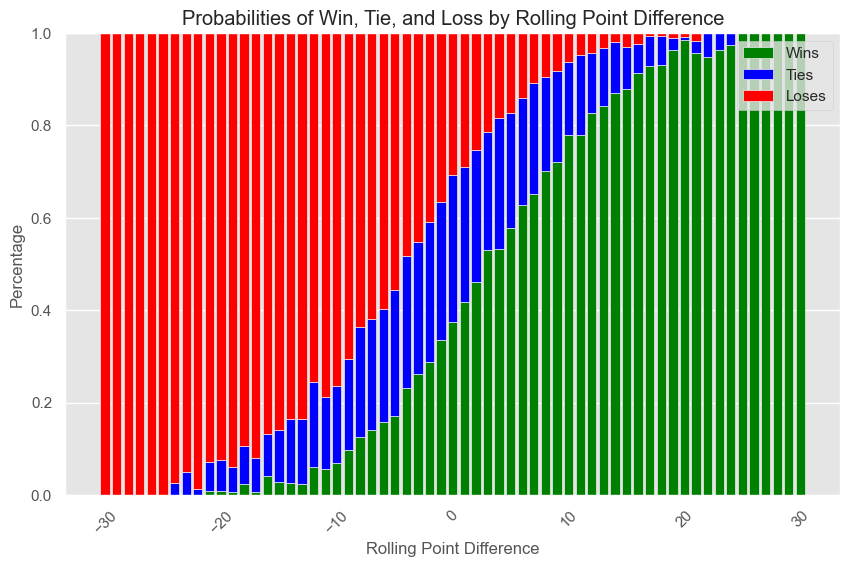

In [38]:
# Set the aesthetic style of the plots
plt.style.use('ggplot')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the starting point for the 'tie_probability' stack
tie_bottom = stats_point_diff['win_probability']

# Calculate the starting point for the 'lose_probability' stack
lose_bottom = stats_point_diff['win_probability'] + stats_point_diff['tie_probability']

# Create a bar plot for 'win_probability'
ax.bar(stats_point_diff.index, stats_point_diff['win_probability'], label='Wins', color='green')

# Create a bar plot for 'tie_probability', starting on top of 'win_probability'
ax.bar(stats_point_diff.index, stats_point_diff['tie_probability'], bottom=tie_bottom, label='Ties', color='blue')

# Create a bar plot for 'lose_probability', starting on top of the sum of 'win_probability' and 'tie_probability'
ax.bar(stats_point_diff.index, stats_point_diff['loss_probability'], bottom=lose_bottom, label='Loses', color='red')

# Add title and labels
ax.set_title('Probabilities of Win, Tie, and Loss by Rolling Point Difference')
ax.set_xlabel('Rolling Point Difference')
ax.set_ylabel('Percentage')
ax.legend()  # Add a legend to distinguish the layers

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

## ROLLING SCORE DIFFERENCE

In [47]:
# First, perform the aggregation to sum wins and count games:
stats_score_diff = df_results.groupby('rolling_score_diff').agg(
    total_wins=('points', lambda x: (x == 3).sum()),  # Summing the boolean 'win' column to count True values.
    total_ties=('points', lambda x: (x == 1).sum()),
    total_losses=('points', lambda x: (x == 0).sum()),
    total_games=('points', 'count')  # Counting all rows to get the number of games.
)

# Now, calculate the probability of wins:
stats_score_diff['win_probability'] = stats_score_diff['total_wins'] / stats_score_diff['total_games']
stats_score_diff['tie_probability'] = stats_score_diff['total_ties'] / stats_score_diff['total_games']
stats_score_diff['loss_probability'] = stats_score_diff['total_losses'] / stats_score_diff['total_games']

stats_score_diff

total_wins  total_ties  total_losses  total_games  \
rolling_score_diff                                                      
-128.0                       0           0             1            1   
-123.0                       0           0             1            1   
-120.0                       0           0             1            1   
-116.0                       0           0             2            2   
-110.0                       0           0             1            1   
...                        ...         ...           ...          ...   
 121.0                       1           0             0            1   
 122.0                       1           0             0            1   
 135.0                       1           0             0            1   
 140.0                       1           0             0            1   
 154.0                       1           0             0            1   

                    win_probability  tie_probability  loss_probability  
rolling_score_diff                                                      
-128.0                          0.0              0.0               1.0  
-123.0                          0.0              0.0               1.0  
-120.0                          0.0              0.0               1.0  
-116.0                          0.0              0.0               1.0  
-110.0                          0.0              0.0               1.0  
...                             ...              ...               ...  
 121.0                          1.0              0.0               0.0  
 122.0                          1.0              0.0               0.0  
 135.0                          1.0              0.0               0.0  
 140.0                          1.0              0.0               0.0  
 154.0                          1.0              0.0               0.0  

[209 rows x 7 columns]

In [53]:
dataframe = stats_score_diff
minimum = -50
maximum = 50

filtered_stats = dataframe[(dataframe.index > minimum)&(dataframe.index < maximum)]
# Print the filtered results
filtered_stats

total_wins  total_ties  total_losses  total_games  \
rolling_score_diff                                                      
-49.0                        0           2            35           37   
-48.0                        1           1            27           29   
-47.0                        1           3            28           32   
-46.0                        0           3            28           31   
-45.0                        2           4            32           38   
...                        ...         ...           ...          ...   
 45.0                       43           0             0           43   
 46.0                       38           0             0           38   
 47.0                       37           0             0           37   
 48.0                       33           2             3           38   
 49.0                       32           2             0           34   

                    win_probability  tie_probability  loss_probability  
rolling_score_diff                                                      
-49.0                      0.000000         0.054054          0.945946  
-48.0                      0.034483         0.034483          0.931034  
-47.0                      0.031250         0.093750          0.875000  
-46.0                      0.000000         0.096774          0.903226  
-45.0                      0.052632         0.105263          0.842105  
...                             ...              ...               ...  
 45.0                      1.000000         0.000000          0.000000  
 46.0                      1.000000         0.000000          0.000000  
 47.0                      1.000000         0.000000          0.000000  
 48.0                      0.868421         0.052632          0.078947  
 49.0                      0.941176         0.058824          0.000000  

[99 rows x 7 columns]

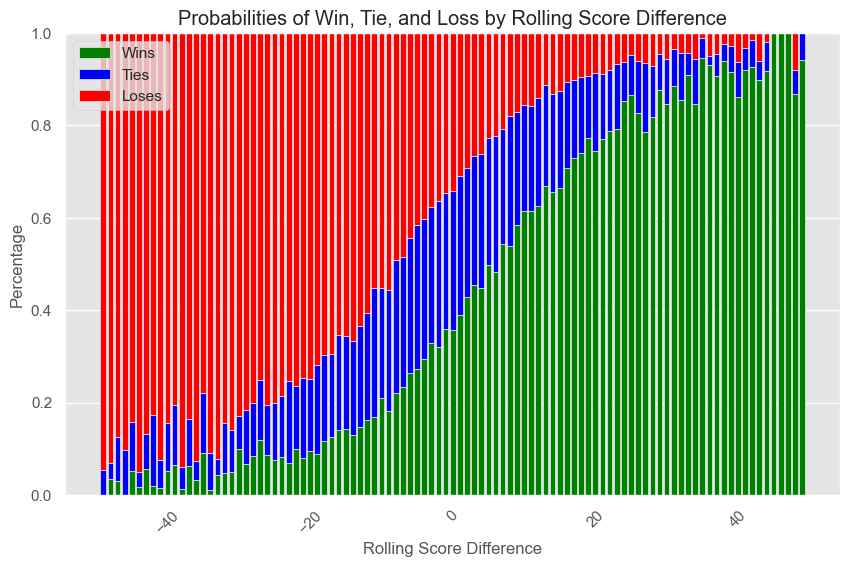

In [54]:
printed_df = filtered_stats

# Set the aesthetic style of the plots
plt.style.use('ggplot')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the starting point for the 'tie_probability' stack
tie_bottom = printed_df['win_probability']

# Calculate the starting point for the 'lose_probability' stack
lose_bottom = printed_df['win_probability'] + printed_df['tie_probability']

# Create a bar plot for 'win_probability'
ax.bar(printed_df.index, printed_df['win_probability'], label='Wins', color='green')

# Create a bar plot for 'tie_probability', starting on top of 'win_probability'
ax.bar(printed_df.index, printed_df['tie_probability'], bottom=tie_bottom, label='Ties', color='blue')

# Create a bar plot for 'loss_probability', starting on top of the sum of 'win_probability' and 'tie_probability'
ax.bar(printed_df.index, printed_df['loss_probability'], bottom=lose_bottom, label='Loses', color='red')

# Add title and labels
ax.set_title('Probabilities of Win, Tie, and Loss by Rolling Score Difference')
ax.set_xlabel('Rolling Score Difference')
ax.set_ylabel('Percentage')
ax.legend()  # Add a legend to distinguish the layers

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

## ELO DIFFERENCE

In [55]:
# First, perform the aggregation to sum wins and count games:
stats_elo_diff = df_results.groupby('elo_diff').agg(
    total_wins=('points', lambda x: (x == 3).sum()),  # Summing the boolean 'win' column to count True values.
    total_ties=('points', lambda x: (x == 1).sum()),
    total_losses=('points', lambda x: (x == 0).sum()),
    total_games=('points', 'count')  # Counting all rows to get the number of games.
)

# Now, calculate the probability of wins:
stats_elo_diff['win_probability'] = stats_elo_diff['total_wins'] / stats_elo_diff['total_games']
stats_elo_diff['tie_probability'] = stats_elo_diff['total_ties'] / stats_elo_diff['total_games']
stats_elo_diff['loss_probability'] = stats_elo_diff['total_losses'] / stats_elo_diff['total_games']

stats_elo_diff

total_wins  total_ties  total_losses  total_games  \
elo_diff                                                          
-1468.098006           0           0             1            1   
-1408.689162           0           0             1            1   
-1400.514865           0           0             1            1   
-1384.425286           0           0             1            1   
-1382.988368           0           0             1            1   
...                  ...         ...           ...          ...   
 1417.727057           1           0             0            1   
 1431.258104           1           0             0            1   
 1436.977102           1           0             0            1   
 1442.459489           1           0             0            1   
 1471.842908           1           0             0            1   

              win_probability  tie_probability  loss_probability  
elo_diff                                                          
-1468.098006              0.0              0.0               1.0  
-1408.689162              0.0              0.0               1.0  
-1400.514865              0.0              0.0               1.0  
-1384.425286              0.0              0.0               1.0  
-1382.988368              0.0              0.0               1.0  
...                       ...              ...               ...  
 1417.727057              1.0              0.0               0.0  
 1431.258104              1.0              0.0               0.0  
 1436.977102              1.0              0.0               0.0  
 1442.459489              1.0              0.0               0.0  
 1471.842908              1.0              0.0               0.0  

[47399 rows x 7 columns]

In [82]:
# Define bin edges for clustering in steps of 50 points
bin_edges = range(int(stats_elo_diff.index.min() // 100) * 100, int(stats_elo_diff.index.max() // 100 + 1) * 100 + 100, 100)

# Create bin labels
bin_labels = [f'{edge}-{edge + 100}' for edge in bin_edges[:-1]]

# Add a new column for the bins
stats_elo_diff['elo_bin'] = pd.cut(stats_elo_diff.index, bins=bin_edges, labels=bin_labels, right=False)

# Aggregate data by the new bins
clustered_df = stats_elo_diff.groupby('elo_bin').agg(
    total_wins=('total_wins', 'sum'),
    total_ties=('total_ties', 'sum'),
    total_losses=('total_losses', 'sum'),
    total_games=('total_games', 'sum'),
    win_probability=('win_probability', 'mean'),
    tie_probability=('tie_probability', 'mean'),
    loss_probability=('loss_probability', 'mean')
)

print(clustered_df)

             total_wins  total_ties  total_losses  total_games  \
elo_bin                                                          
-1500--1400           0           0             3            3   
-1400--1300           0           0             8            8   
-1300--1200           0           0            13           13   
-1200--1100           0           0            30           30   
-1100--1000           0           0            34           34   
-1000--900            0           2            57           59   
-900--800             0           1           139          140   
-800--700             1           6           235          242   
-700--600            12          42           404          458   
-600--500            27          93           681          801   
-500--400            95         245          1240         1580   
-400--300           323         543          1857         2723   
-300--200           748        1031          2679         4458   
-200--100 

/var/folders/pv/_5sm602j72l3cgb0f_2z74300000gp/T/ipykernel_94413/3590230707.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clustered_df = stats_elo_diff.groupby('elo_bin').agg(


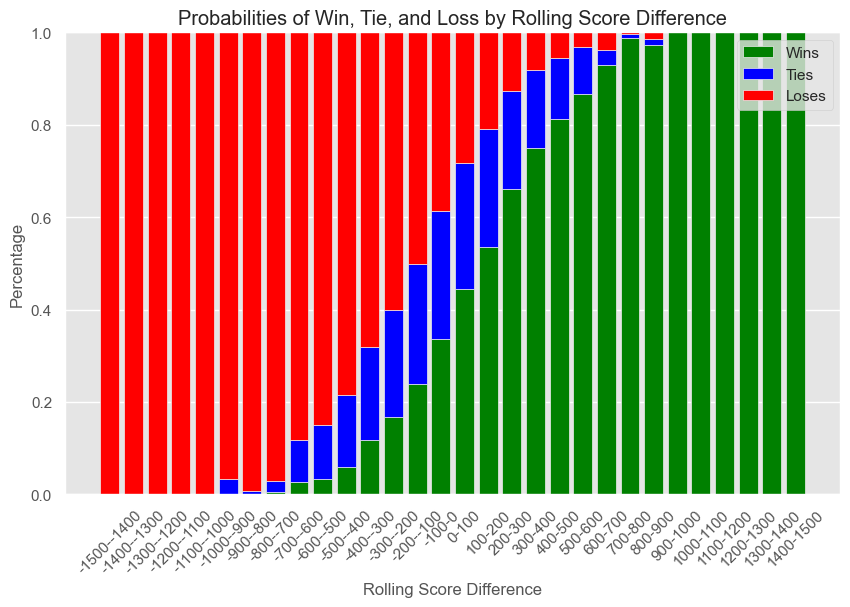

In [83]:
printed_df = clustered_df

# Set the aesthetic style of the plots
plt.style.use('ggplot')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the starting point for the 'tie_probability' stack
tie_bottom = printed_df['win_probability']

# Calculate the starting point for the 'lose_probability' stack
lose_bottom = printed_df['win_probability'] + printed_df['tie_probability']

# Create a bar plot for 'win_probability'
ax.bar(printed_df.index, printed_df['win_probability'], label='Wins', color='green')

# Create a bar plot for 'tie_probability', starting on top of 'win_probability'
ax.bar(printed_df.index, printed_df['tie_probability'], bottom=tie_bottom, label='Ties', color='blue')

# Create a bar plot for 'loss_probability', starting on top of the sum of 'win_probability' and 'tie_probability'
ax.bar(printed_df.index, printed_df['loss_probability'], bottom=lose_bottom, label='Loses', color='red')

# Add title and labels
ax.set_title('Probabilities of Win, Tie, and Loss by Rolling Score Difference')
ax.set_xlabel('Rolling Score Difference')
ax.set_ylabel('Percentage')
ax.legend()  # Add a legend to distinguish the layers

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# PREDICTION

## ML PREDICTION

In [90]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [92]:
df_results

date         team  points  team_goals  net_score  rolling_points  \
0     1872-11-30     Scotland       1           0          0             1.0   
1     1873-03-08      England       3           4          2             4.0   
2     1874-03-07     Scotland       3           2          1             4.0   
3     1875-03-06      England       1           2          0             5.0   
4     1876-03-04      England       0           0         -3             5.0   
...          ...          ...     ...         ...        ...             ...   
47394 2024-07-10  Netherlands       0           1         -1            19.0   
47395 2024-07-10      Uruguay       0           0         -1            20.0   
47396 2024-07-13      Uruguay       1           2          0            18.0   
47397 2024-07-14      England       0           1         -1            16.0   
47398 2024-07-14        Spain       3           2          1            28.0   

       rolling_net_score  team_elo_rating  opponent  opponent_points  \
0                    0.0      1805.268048   England                1   
1                    2.0      2114.383980  Scotland                0   
2                   -1.0      1810.906287   England                0   
3                    1.0      2098.973981  Scotland                1   
4                   -2.0      2089.129704  Scotland                3   
...                  ...              ...       ...              ...   
47394               14.0      2152.709569   England                3   
47395               14.0      2083.380232  Colombia                3   
47396               12.0      2076.634543    Canada                1   
47397                4.0      2174.447759     Spain                3   
47398               20.0      2261.484417   England                0   

       opponent_goals  opponent_net_score  opponent_rolling_points  \
0                   0                   0                      1.0   
1                   2                  -2                      1.0   
2                   1                  -1                      4.0   
3                   2                   0                      5.0   
4                   3                   3                      8.0   
...               ...                 ...                      ...   
47394               2                   1                     16.0   
47395               1                   1                     28.0   
47396               2                   0                     10.0   
47397               2                   1                     28.0   
47398               1                  -1                     16.0   

       opponent_rolling_net_score  opponent_elo_rating  rolling_points_diff  \
0                             0.0          2114.672636                  0.0   
1                            -2.0          1805.556703                  3.0   
2                             1.0          2109.034396                  0.0   
3                            -1.0          1820.966703                  0.0   
4                             2.0          1830.810980                 -3.0   
...                           ...                  ...                  ...   
47394                         4.0          2173.943887                  3.0   
47395                        20.0          2158.452391                 -8.0   
47396                        -6.0          1800.676134                  8.0   
47397                        20.0          2257.272422                -12.0   
47398                         4.0          2170.235764                 12.0   

       rolling_score_diff    elo_diff  
0                     0.0 -309.404588  
1                     4.0  308.827277  
2                    -2.0 -298.128109  
3                     2.0  278.007278  
4                    -4.0  258.318724  
...                   ...         ...  
47394                10.0  -21.234318  
47395                -6.0  -75.072159  
47396                18.0  275.95840

In [150]:
input = df_results.drop(columns=["date","team","opponent","points","opponent_points","team_goals","opponent_goals","net_score","opponent_net_score"])
output = df_results[["team_goals","opponent_goals"]]
#input.value_counts()
output.value_counts()

team_goals  opponent_goals
1           1                 4660
            0                 4263
0           1                 3942
            0                 3789
2           1                 3167
                              ... 
0           24                   1
1           17                   1
            16                   1
9           4                    1
31          0                    1
Name: count, Length: 138, dtype: int64

In [ ]:
# Split data into training and testing sets
input_train, input_test, output_train, output_test = train_test_split(input, output, test_size=0.25, random_state=42)

# Initialize a base regressor
base_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Use MultiOutputRegressor to handle multiple outputs
multi_output_regressor = MultiOutputRegressor(base_regressor)

# Train the model
multi_output_regressor.fit(input_train, output_train)

# Make predictions
output_pred = multi_output_regressor.predict(input_test)

# Convert predictions to integers
output_pred_round = output_pred.round().astype(int)

# Evaluate the model
mse_team_goals = mean_squared_error(output_test['team_goals'], output_pred_round[:, 0])
mse_opponent_goals = mean_squared_error(output_test['opponent_goals'], output_pred_round[:, 1])

print(f"Mean Squared Error for Goals Shot: {mse_team_goals}")
print(f"Mean Squared Error for Goals Got: {mse_opponent_goals}")

# Optionally, print out predictions to review
print(f"Predictions (Goals Shot, Goals Got): {output_pred_round}")

In [102]:
def train_multi_output_regressor(input,output):
    # Split data into training and testing sets
    input_train, input_test, output_train, output_test = train_test_split(input, output, test_size=0.25, random_state=42)

    # Initialize a base regressor
    base_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

    # Use MultiOutputRegressor to handle multiple outputs
    multi_output_regressor = MultiOutputRegressor(base_regressor)

    # Train the model
    multi_output_regressor.fit(input_train, output_train)

    return multi_output_regressor

In [103]:
trained_multi_output_model = train_multi_output_regressor(input,output)

In [157]:
# Saving the trained model
with open('model/trained_multi_output_model.pkl', 'wb') as file:
    pickle.dump(trained_multi_output_model, file)

In [ ]:
# Load the model
with open('model/trained_multi_output_model.pkl', 'rb') as file:
    trained_multi_output_model = pickle.load(file)

In [154]:
df_results.to_csv('data/modified_results.csv', index=False)


# PROVIDE

In [124]:
def get_latest_team_data(team_name):
        # Combine filtering and getting the last record into one step
        team_data = df_results[(df_results["team"] == team_name) | (df_results["opponent"] == team_name)].iloc[-1]

        if team_data["team"] == team_name:
            rolling_points = team_data["rolling_points"]
            rolling_net_score = team_data["rolling_net_score"]
            elo_rating = team_data["team_elo_rating"]
            
        else:
            rolling_points = team_data["opponent_rolling_points"]
            rolling_net_score = team_data["opponent_rolling_net_score"]
            elo_rating = team_data["opponent_elo_rating"]
        
        return rolling_points, rolling_net_score, elo_rating

def create_match(team1,team2):
     # Get the latest data for both teams
    team1_rolling_points, team1_rolling_net_score, team1_elo_rating = get_latest_team_data(team1)
    team2_rolling_points, team2_rolling_net_score, team2_elo_rating = get_latest_team_data(team2)

    rolling_points_diff = team1_rolling_points - team2_rolling_points
    rolling_net_score_diff = team1_rolling_net_score - team2_rolling_net_score
    elo_rating_diff = team1_elo_rating - team2_elo_rating

    input_data = pd.DataFrame([[team1_rolling_points, team1_rolling_net_score, team1_elo_rating, 
                                team2_rolling_points, team2_rolling_net_score, team2_elo_rating,rolling_points_diff,rolling_net_score_diff,elo_rating_diff]],
                              columns=input.columns)
    
    return input_data


def ml_simulate_match(input_data):
    # Predict the match outcome
    prediction = trained_multi_output_model.predict(input_data)
    
    # Convert predictions to integers
    prediction_round = prediction.round().astype(int)

    return prediction_round



In [151]:
team1 = "Austria"
team2 = "Turkey"

match_data = create_match(team1,team2)
result = ml_simulate_match(match_data)
print(f"{team1} {result[0][0]} :  {team2} {result[0][1]}")
print(match_data["rolling_points_diff"][0])
print(match_data["rolling_score_diff"][0])
print(match_data["elo_diff"][0])

Austria 2 :  Turkey 1
11.0
20.0
39.53800286822752


git commit -m "Describe your changes here"

git push